### Part 1: Matrix Factorization


The design choices that I had when implementing the LSA decomposition was the word embeddings: do I want them to be $U$ or $U\Sigma$. I decided I wanted to leverage the scaling by the singular values, and this is something I took into account when working with this decomposition. In the nearest neighbours helper function, I decided to use the cosine distance (bounded by 1 from above in this case) instead of the euclidian distance.


### a. Relationship between $U_{tt}$ and $U_{td}$

Let us write the SVD for $W_{tt}$ and $W_{td}$.

$$W_{tt} = U_{tt}\Sigma_{tt}V_{tt}^T$$
$$W_{td} = U_{td}\Sigma_{td}V_{td}^T$$
Furthermore, we have $W_{tt} = W_{td}W_{td}^T$. 
And $$W_{td}W_{td}^T = U_{td}\Sigma_{td}V_{td}^TV_{td}\Sigma_{td}^TU_{td}^T$$
Now, we can usee the identity $V_{td}^TV_{td} = Id$ and get 
$$W_{tt} = U_{td}\Sigma_{td}\Sigma_{td}^TU_{td}^T$$
Now, since $W_{tt}$ is diagonalizable and $\Sigma_{td}\Sigma_{td}^T$ is diagonal, we can identify the decomposition and identify that the left singular vectors of $W_{tt}$ and $W_{td}$ are identical.

I observe this behavior with my implementation of LSA, after having taken care of normalizing via the square root of singular values (sorted singular values). 

### b. Representation space

In order to handle the different parameters (and in this specific case, the dimension of the LSA), I performed incremental analysis: tf-idf, cosine vs euclidian distances and careful design of the LSA representation (ie careful choice of the dimension of LSA in an Unsupervised way).

#### Representation space with the tf-idf matrix

We can see that, leveraging only the tf-idf matrix creates embeddings that make some sense in terms of semantic association. 
I decided to analyze the representation space looking back at our desiderata for distributional semantics:
- Semantic association: From the examples of the notebook, we can see that the words associated with 'the' and 'good' make sense in semantic association
- Type association: we can see with some further examples that the type association is respected (nouns vs verbs)

#### Influence of the size of the LSA representation, and careful design choice for the dimension of LSA

##### Motivation

One interesting thing to notice is that the Euclidian distance between words and their surroundings allow to know how good we surroung a word in High-Dimensionality. But one pattern that we start discovering is that **the closest words are actually far away**. This is due to the fact that, in high dimensions we are all alone: Curse of Dimensionality (Folks theorem). Therefore, when we increase the size of LSA, we will account for more features and allow for more separation and maybe a better clustering, but we will prevent our model from learning 'stratiications' in the representation space. Reducing the size of LSA will create more 'compact' representations, but maybe we will lose some information by projecting into a subspace and letting go some information brought by marginal singular vectors (maybe their own contribution is low, but this technique prevents from considering multivariate effect). 
Therefore, let us choose this trade-off by visualizing the scaled variance of every eigenvalue, being a proxy for the contribution of the corresponding eigenvector. 

##### Neighborhood in High Dimensionality

For this experiment, we are going to choose the 4 words 'the', 'dog', '3', and 'good' and check how the mean distance to their 5 closest neighbors evolve with the dimensionality of the LSA. The question would be: is varying the dimensionality of LSA having an influence on which words are closest to each others ? 
The result of this experiment is displayed in the appendix. From this experiment, several interesting things appear:
- As expected, when truncating into a very low dimensional space, all the words are very close to another and the closest neighborhood is at cosine distance 1.
- When increasing the dimensionality of the LSA representation, the closest neighbours seem do make more sense, with syntactic similarities between words and even meaningful nearest neighbors
- When the size of the LSA is too big, nearest neighbours do not make much sense anymore, and they are all closely related to stop words, which occur everywhere
- This confirms our intuition that there is a serious trade-off in finding the optimal dimension for the LSA

##### Finding the optimal dimension for the LSA : heuristic with the cumulated variance

Since the LSA is done on the tf-idf matrix, we are going to apply our heuristic on this matrix. We know that the singular values can be expressed as the square roots of the eigenvalues of the empirical covariance matrix. 

Implementation detail: we take the absolute value because we know that $XX^T$ is SDP (where $X$ is the tf-idf matrix), so the eigenvalues must be positive, and compute their square root and then normalize the eigenvalues by the trace of the matrix: this gives a normalized contribution of every eigenvalue. The result from this experiment is that 1028 dimensions are necessary to retain $80%$ of the variance contained in the LSA matrix, which is a bit overtestimated according to our plot. Leveraging the *marginalized* contribution of every eigenvalue provides a result a bit less conservative, but that seems more interpretable. 

### c. Effect on downstream, classification task

From the results in the notebook, we can see that the performances on the downstream classification task of the different representations vary significantly: with only the word featurizer: 0.784, only lsa: 0.786, combo: 0.802.

#### Influence of dimension

As we have seen before, there is definitely a trade off in dimensionality reduction: we need to find the 'sweet-spot'. Before, we did that in an Unsupervised Way using variance retained. Now that we have a downstream classification task, we could fine-tune our representations based on this classification task. We are going to do that on the validation set, and find which is the effect of representation on classification.We will be working with the combo_featurizer in order to understand the contribution of both vectorized words and LSI representations. Why working on the validation set ? Because here we interpret the size of LSI as a hyperparameter, and the validation set is kept for Hyperparameter tuning. Please refer to the appendix for the result of this experiment.
Therefore, we can see that selecting carefully the dimension of the embedding space might provide us with huge benefits regarding the performances boost brought on by the LSA embeddings. 

#### Influence of the number of labelled examples

Intuition: what happens when the number of labeled data diminishes ? The compression becomes **less** efficient. Indeed, let us have a toy example: 10000 examples and LSI with 1000 dimensions: we have a 10 $\times$ compression and  the information will be efficiently encoded efficiently. However, if we have 1000 examples and LSI with 1000 dimensions: data will be very sparse. Therefore, intuitively, allowing for a large vocabulary size (brought by a big number of reviews) allow our unsupervised learning model to learn some patterns in rich structures. Therefore, I think that the effect of representations will be less effective when having less labelled data points. 

This is corroborated by the result of the experiment (please see Appendix).

### Part 2: Word representations via language modeling


In order to implement the Word2Vec Neural Network, I decided to encode every word (token) as a one-hot vector, to then be able to compute the mean of the words in a context (at least the relevant words, ie the positive in this case). Regarding the layers, I decided to only use linear layers (even for the output, the softmax will be done in the loss function). This is because I wanted to investigate what authors have called **Additive COmpositionality**. Regarding the loss, I am using the Sparse Categorical Binary Cross Entropy. The two hyperparameters of this problem are the embedding dimension and the context size. 


#### a. Language Modeling

##### Intuition and analysis
From the different experiments, two patterns seem to emerge from the Word2Vec representations: 
- they seem **very relevant** in terms of association. In the embedding spaces, words seem to be closer to other ones that have same meaning (or at least the same function in the sentence). 
- Moreover, the KMeans clusters created on the algorithm seem to correspond to some specific classes (please see Appendix)
- I think that these representations are very intuitive and seem to encode **word similarity**, in the sense that words that could be used in an exchangeable way (ie without changing the **syntactic correctness of the sentence**) seem to be inside the same category.

##### Verifying the linear structure: Additive Compositionality

In the initial paper released by Mikolov et al. *Distributed Representations of Words and Phrases and their Compositionality*, we saw that non-linearities were **not used** because it allows the representations to present a linear pattern. Let us verify if this also happens in this representation. In this experiment, I selected two words, computed their substractio in the embedding space and then computed the closest word in the embedding space to the substraction. Two results that I got are:
$v_{hard}$ - $v_{easy} \approx 0$ (antonym) and $v_{fat} - v_{eat} \approx v_{protein}$ (complementary words). These results look amazing 

##### Analogical Reasoning

When visualizing the similar words with Word2Vec representations, we can see that our intuition was right in the sense that similar words are very similar in the embedding space.

#### b. c. Downstream Classification as a benchmarking method and Context Size

Here, since we only use the word2vec embeddings for the representation, we will compare the performances of using only word2vec embeddings with the performances of using only lsa featurizer. We can see that the performances of using word2vec are slightly worse than when using lsa_featurizer (with some careful design). However, the advantages of using word2vec are:
- More flexibility in the representation
- Tractable computations in a NN
- Results more interpretable

Last, we still haven't taken into account a fundamental parameter in the word2vec implementation: the **embedding size** (which was equivalent, in the LSA to the dimension of the truncated SVD). Let us Cross-Validate on a few different embedding dimension, and check which influence does this parameter have on the downstream task. 

##### Influence of the Embedding Dimension

Our hope is that after fine-tuning the embedding dimension, we have the opportunity to improve a lot our classification performances, and get significantly better results with the Word2Vec embeddings than with the LSA embeddings. A priori, here is my thought: the embedding dimension becomes the number of features for the Linear classifier. Since we have onlty $3000$ training examples, selecting the embedding dimension as being greater than $3000$ creates an over-specified problem and raises issues with computational stability of the estimates: we don't want tot do that. For smaller embedding dimensions, when we increase the number of dimensions, it becomes harder for our classifier to learn useful patterns in our data (more fetaures, same amout on training data): this is where the tradeoff happens: there is a need to select carefully the number of dimensions. Please refer to the appendix for the result of this experiment.

We can see that the results confirm or intuition regarding the Embedding dimension. We even get results that are similar with Word2Vec Embeddings than with LSA Embeddings. Another hyperparameter that might affect performances of Word2Vec is the **context size**. Let us explore how this parameter might affect performances, and later on we will see its influence on the *representation*. So let's perform the following experiment: fixing the embedding dimension to 1000, we will vary the context size and check how this affects performances. 

##### Influence of the context size on the downstream classification task

We can see from the result of the experiment (displayed on the appendix) that the context size has also a crucial importance on the downstream classification task and selecting it carefully is important to get good performances.

##### Influence of the context size on the representation space: please refer to Appendix


### Part 3: HMM
#### a. Defining a specific set of sequences

In order to construct an HMM in order to restrict the generated sequences to these sequences, I decided to create 8 latent spaces: 01, 02, 12, 13, 20, 21, 30, 31. Each one of these $8 q_i$ will allow only the transition from $q_{ij}$ to $q_{ji}$ (encoded in the matrix transition A, which is a permutation matrix).  For the emission probabilities, the matrix B has been designed such as, if the hidden state is $q_{ij}$, I can only emit the token $j$. Therefore, the HMM follows a dynamic: $q_{ij} \mapsto q_{ji}$ and emitting $j$, $q_{ji} \mapsto q_{ij}$ and emitting $i$ and circling in this dynamics. It is therefore only determined by the initial distribution $\pi$, which assigns probabilities to states emitting 0 or 1, $q_{i0}$ and $q_{i1}$.

#### b. Information captured by Hidden States

In order to compare the information encoded in hidden states when varying the number of hidden states, I am going to train the entire HMM model on the corpus, with different number of states (2, 10 and 100) and try to qualitatively analyze the composition of the most probable words in these states. I chose to work on the entire corpus and not selecting a subset of the training portion because I wanted to capture important patterns in the data. 

##### With 2 states

In addition to printing the most probable words for every hidden state, I selected an arbitrary review and labelled every word inside it according to our HMM. The result of this labelling method is displayed in the appendix. According to the previous analysis and the most probable words per hidden state, we can infer that the learned hidden states seem to encode the following pattern:
- Hidden state (0) seems to encode the **action** terms : where, who, when, what ? Indeed, we can from the previous example that most of action terms seem to be encoded within the hidden state (1). This is quite corroborated by the probabilities of emission when being in state (1)
- Hidden state (1) seems to contain the nouns and transition words. 

So it seems that, with only two hidden states, the separation is quite **syntactic**: hidden state (1) is for noun-related words and hidden state (0) would be more for action-related words. Moreover, we can see that there is somewhat a **class imbalance**: hidden state (0) seems very much more represented than hidden state (1).
    
##### With 10 states

We run the same experiments as the ones with 2 states: most probable words in each hidden state and labelling process.
It is quite more complicated to analyze the information encoded into the learned hidden states with 10 hidden states. Although one mught infer that the hidden states seem to understand which words are paired together: too and pressure (coming from the expression too much pressure) come together in the hidden state (7). One interesting thing stemming from this visualization with 10 hidden states is that different hidden states share the same 'most probable' words (please see the notebook for which words are discussed here).

*Is it something that we want ? Do we want different hidden states to have high probability to sample the same word ?* In my intuition, we don't. This is due to the fact that ultimately we might want to resolve the problem $Q = argmax_Qp(O|Q)$, ie decoding the sequence of hidden states that has produced a specific observation. In these computations, this involve (inside the *Viterbi Search*) $\delta_t(i)$ which will select the most probable hidden state at time step $t$. therefore, if a word has high probabilities of being generated by different sequences, there will be a problem (at the paroxysma of this case) of identifiability. Also, the way I understand the latent space for the HMM we would like to have different hidden states that could be interpreted as latent clusters, and we don't want different clusters to share the same information (otherwise, we would not this this quantity of hidden states). Therefore, I think that this information seems to say that **having $10$ hidden states is too much**.

##### With 100 states

Same analysis, same conclusion ! 


#### c. HMM representations and downstream classification task

Here, we are going to use the same HMM with 10 hidden states for HMM representations. 

*First, what is a HMM representation ?* This reminds me of what is being done in the **LDA** paper, where we represented every distribution with a list of topics and their proportion in the document. Here, we summarize every review with the hidden_states estimated proportion inside the entire review.For our representation, we will be using a HMM that has been trained with 10 hidden states, on the entire training corpus, for 10 updates of the Baum-Welch algorithm. Later on, we will see how the number of hidden states affect the performances of HMM-based representations.

*Are HMM state distributions sensible representations ?* In a way, using HMM states distributions as sentence representations does make sense. Let's say for instance that our hidden states encode for positive/negative review ($q_1$ is positive and $q_2$ is negative). Then, our linear classifier will be able to learn that, since in the training phase, higher proportions of $q_2$ will be associated to a $0$ label. Therefore, we see the importance of carefully selecting the number of hidden states. However, there might be some issues over the fact that **we do not control what is encoded inside hidden states**. Indeed, this point is critically different from LDA, where we allocate our own topics and then the different documents draw topics from a global list of topics: here, the hidden states might be anything, they could be what is encoded in our experiment with 2 hidden states: syntactic structure, which will not help us towards our classification. 
Please refer to the appendix for the result of this experiment. Although not very substantially, we can see that increasing the number of labelled examples help classification thanks to HMM-based sentence representations. But the results are generally worse than in Parts 1 and Parts 2. 

#### d. Equivalence HMM bigrams

- Hypothesis for Bigram Model: the likelihood of an observation $O_{1:T}$ is $p(O_{1:T}) = \prod_{t=1}^{T-1}p(o_{t+1}|o_t)$

Let's consider a HMM with v-states: every state $q_i$ is corresponding to one word $w_i$. This means that $b_i(w_i) = 1$.
Let $O_{1:T}$ be an observation. Under the HMM model, the likelihood of this observation is $p(O_{1:T}) = \sum_Qp(O|Q)p(Q)$.
And we have $$p(O_{1:T}/Q_{1:T}) = \prod_tp(o_t|q_t)
$$ (HMM Hypothesis). 
Therefore, the product is 0 **except** for the very specific sequence where every $q_i$ is corresponding to $w_i$ (being the state for which $b_i(w_i) = 1$, for which the product is equal to $1$. 
We have therefore $p(O_{1:T}) = p(Q^{*}) = \prod_{t=1}^{T-1}p(q_{t+1}^*|q_t^*)$, and since the state $q_t$ is reduced to the observation $o_t$, both models are equivalent. 

In order to be extremely specific, we will create a matrix $A$ where $a_{ij} = p(w_{t+1}|w_t)$, $B$ where $b_{q_t}(o_t) = 1$, and $\pi(q_t) = \frac{|o_t|}{\text{vocab_size}}$

# Appendix

##### 1.a Importance of this result

Now that we have verified this relation, how could this be useful ? The co-occurence matrix is helpful for PMI normalization whereas the term-document matrix is useful for TF-IDF normalization. Once these operations are being done on top of $W_{td}$ or $W_{tt}$, there is no guarantee that the singular vectors will remain the same. This result shows that, without applying any matrix normalization, performing LSA (while choosing the compressed representations as **only** the singular vectors) on the term-document matrix is equivalent to performing LSA on the word co-occurence matrix. Moreover, since we cannot theoritically compute the tf-idf decomposition on $W_{tt}$, this is a way for us to perform LSA on tf-idf for both the term-document and the term-term matrix.


##### 1. b. Why not use the cosine distance ? 

In the readings proposed, the cosine distance was always leveraged in order to deal with word similarity. However, here it was the Euclidian distance. However, after careful analysis, I realized they were the same: Why are they the same ? 
For a vector $u$ such that $||u||=1$,  $$||u-v||^2 = ||u||^2+||v||^2 - 2<u, v>: \min_{v, ||v||=1}||u-v||^2 \iff \min_{v, ||v||=1} -<u, v> \iff \max_{v, ||v||=1} <u, v>
$$
Therefore, minimizing the Euclidian distance is equivalent to maximizing the cosine distance (after a Normalization step).

##### 1b. Representation space in High Dimension 

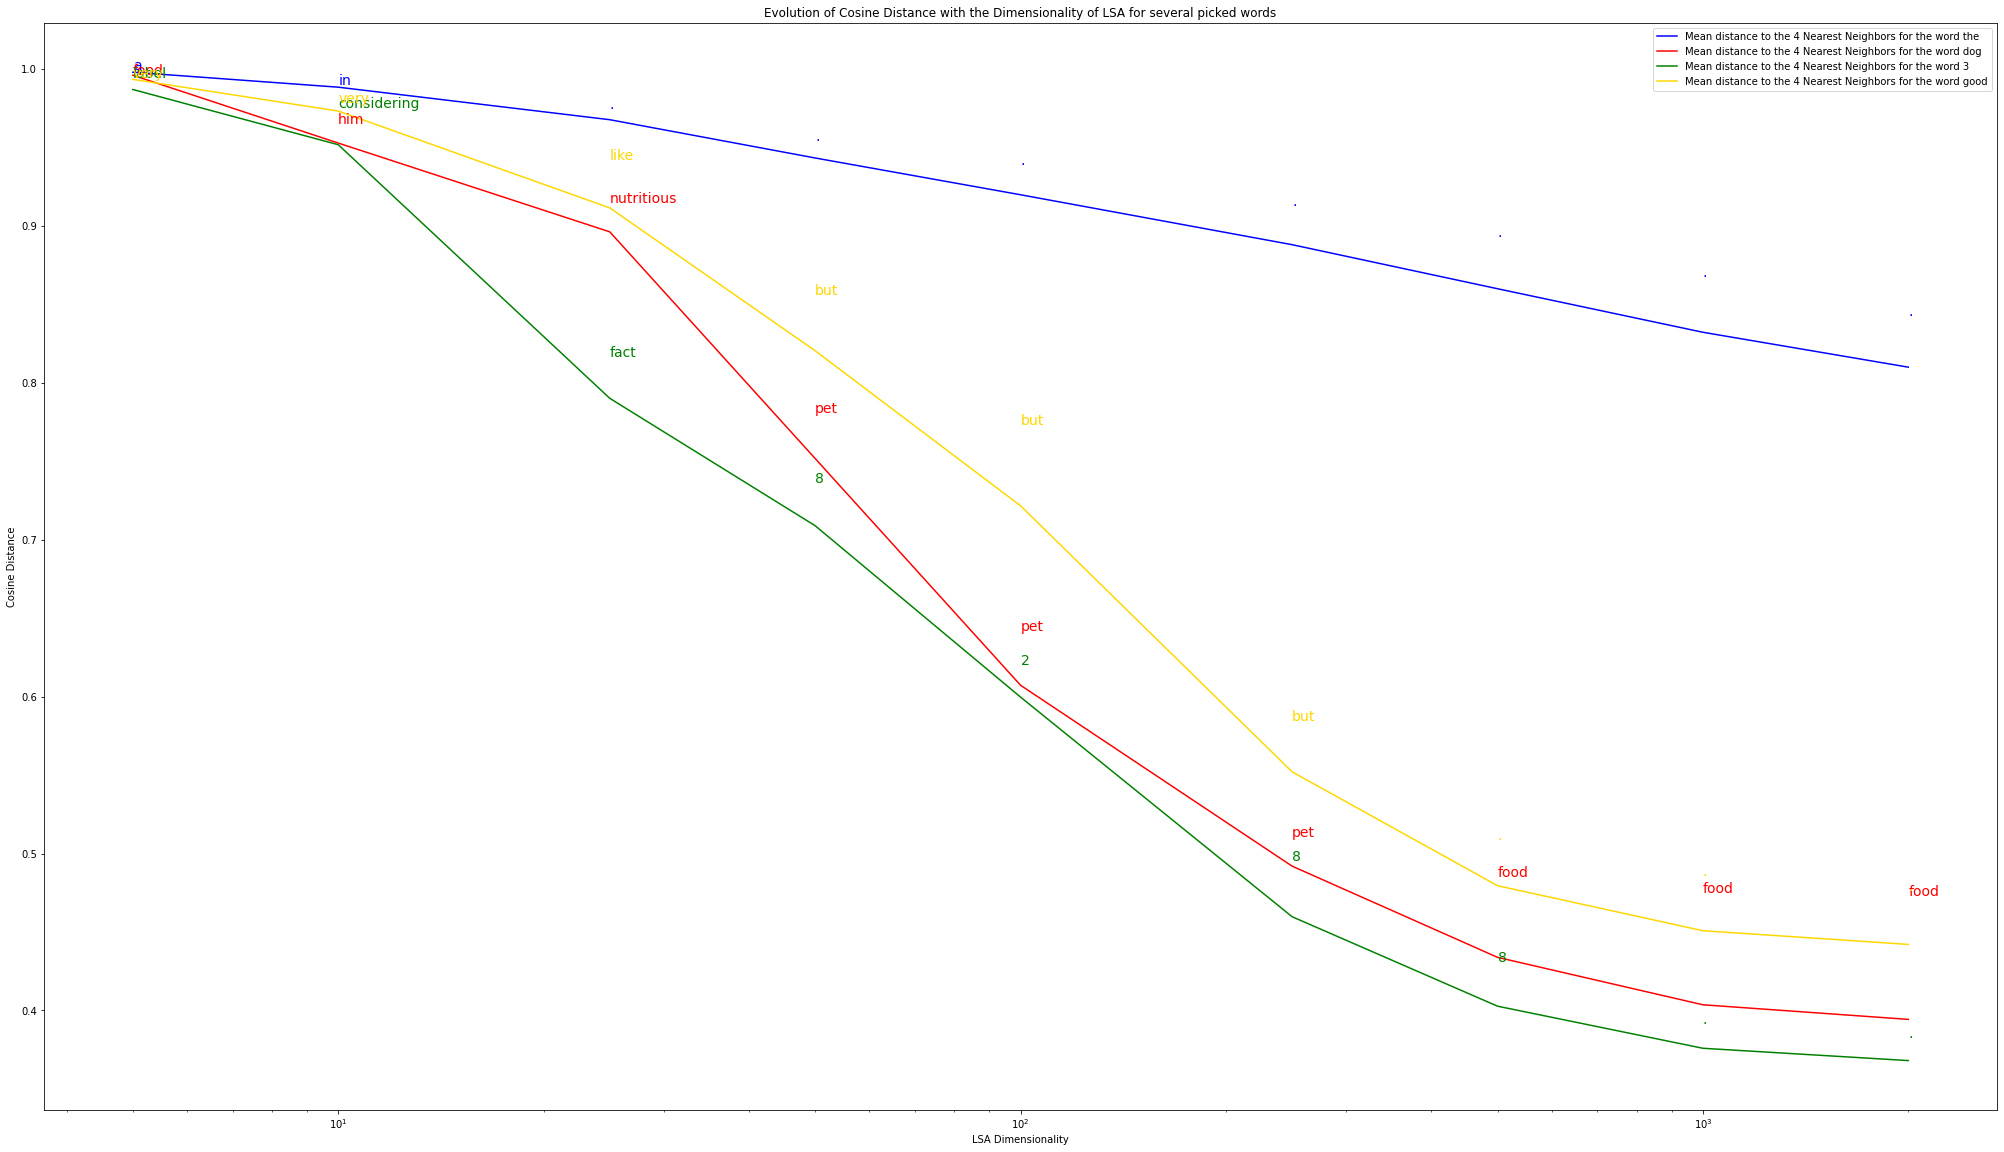

###### 1c. Influence of the dimensionality of LSA on fownstream classification task

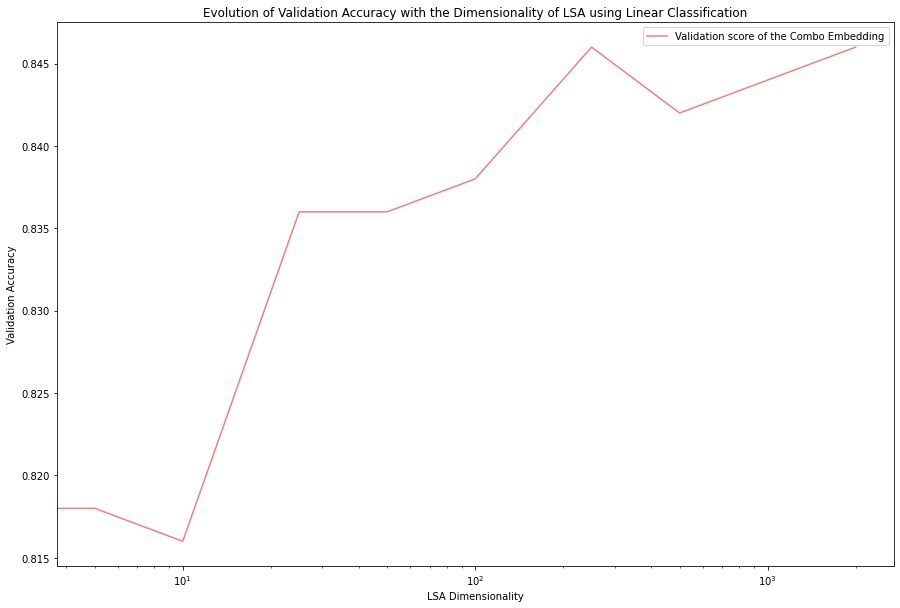

##### 1c. Influence of number of labelled examples, varying every time the dimension of the embedding space

combo features, 500 examples
0.754 

combo features, 500 examples
0.754 

combo features, 500 examples
0.754 

combo features, 500 examples
0.756 

combo features, 500 examples
0.762 

combo features, 500 examples
0.77 

combo features, 500 examples
0.768 

combo features, 1000 examples
0.776 

combo features, 1000 examples
0.776 

combo features, 1000 examples
0.77 

combo features, 1000 examples
0.782 

combo features, 1000 examples
0.784 

combo features, 1000 examples
0.788 

combo features, 1000 examples
0.786 

combo features, 1000 examples
0.786 

combo features, 2000 examples
0.798 

combo features, 2000 examples
0.798 

combo features, 2000 examples
0.8 

combo features, 2000 examples
0.806 

combo features, 2000 examples
0.81 

combo features, 2000 examples
0.814 

combo features, 2000 examples
0.826 

combo features, 2000 examples
0.826 

combo features, 2000 examples
0.83 

combo features, 3000 examples
0.818 

combo features, 3000 examples
0.818 

combo features, 3000 examples
0.816 

combo features, 3000 examples
0.828 

combo features, 3000 examples
0.826 

combo features, 3000 examples
0.842 

combo features, 3000 examples
0.84 

combo features, 3000 examples
0.844 

combo features, 3000 examples
0.844 

combo features, 3000 examples
0.846 

##### 2.a classes 

- Cluster 1: the very common words
  - Cluster 2: the very common nouns
  - Cluster 3: verbs used in a present context
  - Cluster 4: complements to the verbs (terms of action)
  - Cluster 5: verb adjectives
  - Cluster 6: nouns related to food
  - Cluster 7: ?
  - Cluster 8: verbs used in a past context
  - Cluster 9: adjectives used in a context of quantity
  - Cluster 10: Miscellaneous
  
  
###### 2 b, c graph: Accuracy vs Embedding dimension with fixed context size = 2

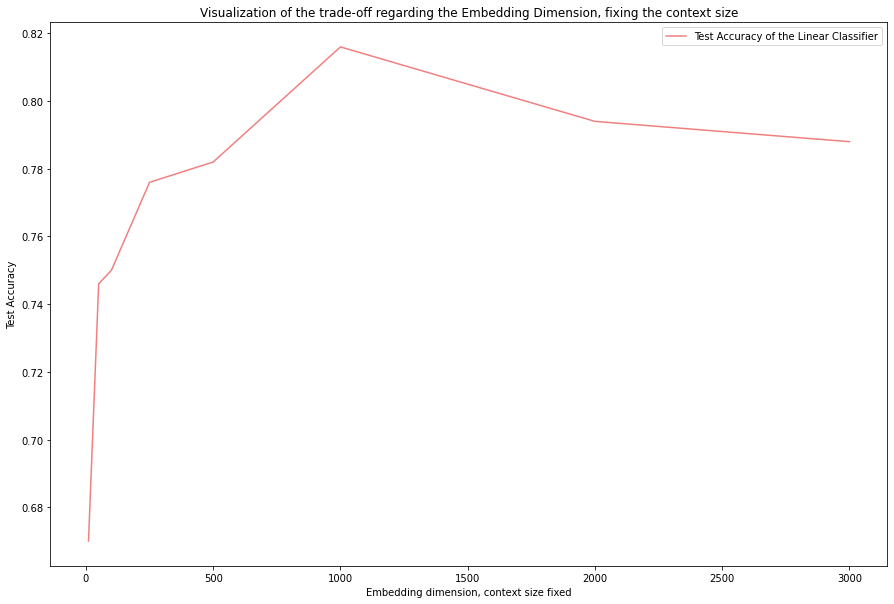

###### 2 b, c graphs: Accuracy vs Context size with fixed Embedding dimension = 1000

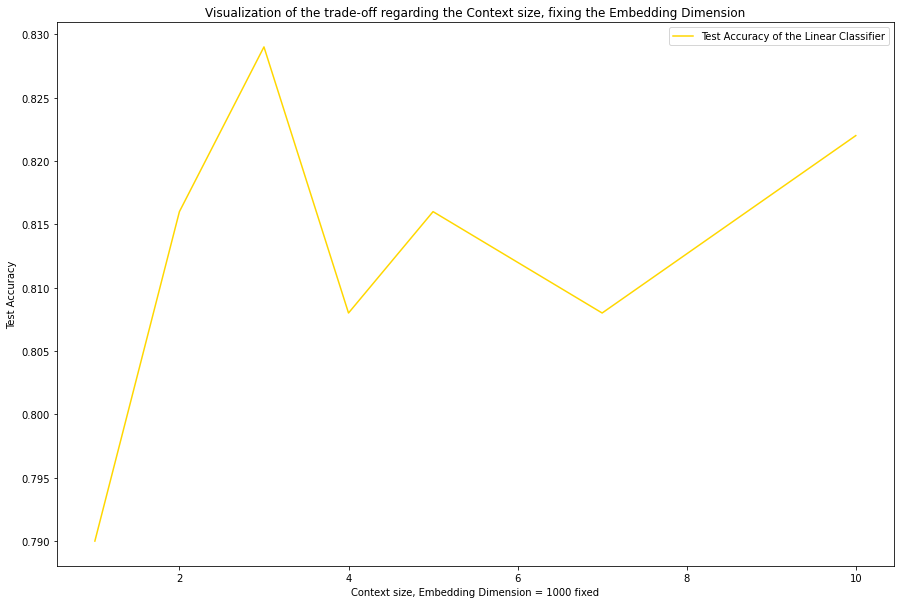

##### 2 c Influence of the context size on the representation space

From the results in the notebook, we can see that the context size has an important influence on the representation space. Indeed, the context size is a proxy for the attention of the model of the context of a word. The larger the context size is, the more of 'context-related' words will be near our target word. When the context size is small, we will be able to encode synonims, or words directly related to this word. Result of the experiment at the end of the notebook ! 

##### 3b. Labelling 2 states

I didn't mind the taste of this very much - it tasted like Minute Maid OJ mixed with soda.  My husband couldn't stand it at all.  My only issue with this was that it was a heavy-syrup sort of flavor that was a little overwhelming.  If there was a better balance of flavor to liquid to make it a little lighter tasting, I think this would be much more refreshing and enjoyable.  Might be fine for kids though - since they like that sugary orange stuff.

i(0) didn't(0) mind(0) the(0) taste(0) of(0) this(0) very(0) much(0) it(0) tasted(0) like(0) minute(1) mixed(0) with(0) soda(1) .(1) my(0) husband(1) couldn't(1) stand(0) it(0) at(0) all(0) .(1) my(0) only(1) issue(1) with(0) this(0) was(0) that(0) it(0) was(0) a(0) heavy(0) syrup(1) sort(0) of(0) flavor(1) that(0) was(0) a(0) little(0) overwhelming(1) .(1) if(0) there(0) was(0) a(0) better(1) balance(1) of(0) flavor(1) to(0) liquid(1) to(0) make(0) it(0) a(0) little(0) lighter(0) tasting(1) ,(0) i(0) think(0) this(0) would(0) be(0) much(0) more(0) refreshing(1) and(0) enjoyable(1) .(1) might(1) be(0) fine(0) for(0) kids(0) though(0) since(1) they(0) like(0) that(0) sugary(0) orange(0) stuff(1) .(1) 

##### 3b. Labelling and counting 10 states

The product stinks and that's mildly stated.  The caps do not snap on easily and if you apply too much pressure the cup part caves in and you end up with ground coffee everywhere.  I threw the whole order into the trash and called it a day.  I will be using professionally produced K-cups (i.e, Dunkin Donuts, Starbucks, even Folgers) from this point on.

the(6) product(6) and(6) that's(7)  stated(0) .(8) the(6)  do(2) not(6)  on(4) easily(8) and(6) if(6) you(6)  too(7) much(6) pressure(7) the(6) cup(3) part(7)  in(7) and(6) you(6) end(6) up(2) with(6) ground(6) coffee(6) ev

Counter({'a': 10, 'unk': 10, '!': 10, '.': 10, '?': 9, 'again': 7, ',': 5, 'review': 5, 'it': 5, 'disappointed': 3, 'thanks': 3, 'lol': 3, 'too': 3, 'flavor': 2, 'buy': 2, 'gum': 2, 'good': 2, 'satisfying': 1, 'batch': 1, 'recommend': 1, ';': 1, 'very': 1, 'not': 1, 'product': 1, 'shipping': 1, '2': 1})


##### 3b. Labelling and counting 100 states

Plocky's Red Beans and Rice Tortilla Chips are really tasty. I shared a few bags with my daughter in Iraq. She said Ummm they are Good. They are good for you too. No artificial stuff.
plocky's(74) red(74) beans(90) and(38) rice(74) tortilla(32) chips(38) are(88) really(4) tasty(81) .(20) i(88) shared(0) a(38) few(78) bags(84) with(90) my(4) daughter(88) in(88) 'unk'(91) .(20) she(57) said(36) 'unk'(91) they(88) are(88) good(90) .(20) they(88) are(88) good(90) for(4) you(38) too(14) .(20) no(28) artificial(88) stuff(90) .(20) 
    
Counter({'.': 100, 'unk': 99, '!': 97, '?': 96, 'a': 89, 'again': 71, ',': 61, 'it': 60, 'too': 48, 'disappointed': 45, 'lol': 39, 'review': 38, ';': 23, 'good': 22, 'flavor': 18, 'buy': 14, 'd': 13, 'shipping': 11, 'gum': 11, 'thanks': 10, 'product': 9, '0': 4, 'com': 3, 'nice': 2, 'br': 2, 'not': 2, 'very': 1, 'the': 1, 'did': 1, 'much': 1, 'eat': 1, 'of': 1, 'many': 1, 't': 1, 'enjoy': 1, 'beware': 1, 'sorry': 1, 'batch': 1, 'popchips': 1})

##### 3c. Performances of downstream classification vs number of training examples for HMM

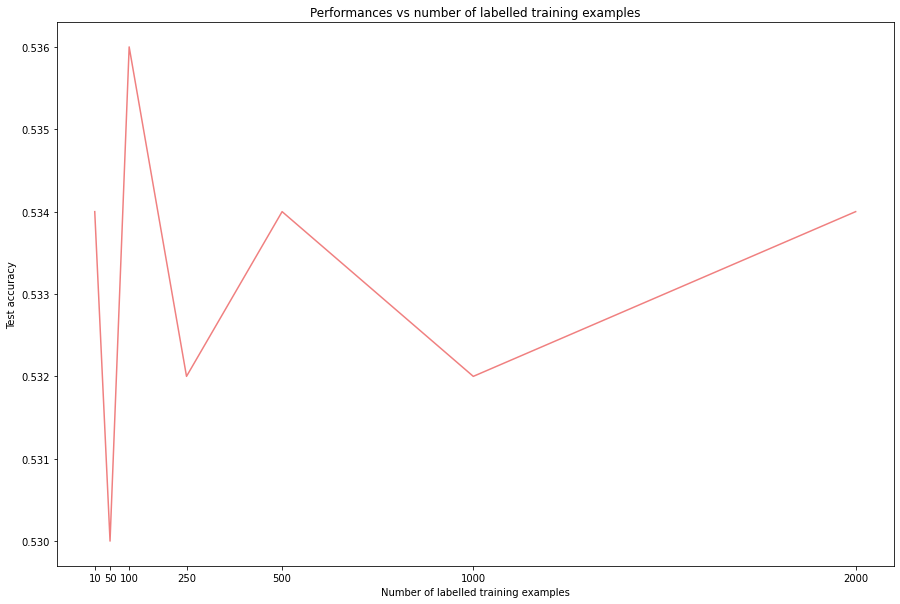